In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akshithawork","key":"979dbd121d8645d5720834a6f138f346"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d grassknoted/asl-alphabet

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
 98% 1.00G/1.03G [00:03<00:00, 306MB/s]
100% 1.03G/1.03G [00:03<00:00, 284MB/s]


In [7]:
import zipfile
import os

zip_file = "asl-alphabet.zip"
extract_path = "sign_language_data"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)

['asl_alphabet_train', 'asl_alphabet_test']

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os

In [12]:
train_dir = os.path.join(extract_path, "/content/sign_language_data/asl_alphabet_train/asl_alphabet_train")
test_dir = os.path.join(extract_path, "/content/sign_language_data/asl_alphabet_test/asl_alphabet_test")

IMG_SIZE = (64, 64)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [13]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 687,837 (2.62 MB)

 Trainable params: 687,389 (2.62 MB)

 Non-trainable params: 448 (1.75 KB)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

EPOCHS = 20

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

Epoch 1/20
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 171s 70ms/step - accuracy: 0.8679 - loss: 0.3921 - val_accuracy: 0.6936 - val_loss: 1.4781
Epoch 2/20
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 170s 69ms/step - accuracy: 0.8829 - loss: 0.3557 - val_accuracy: 0.7132 - val_loss: 0.9942
Epoch 3/20
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 170s 70ms/step - accuracy: 0.8930 - loss: 0.3247 - val_accuracy: 0.7775 - val_loss: 0.7116
Epoch 4/20
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 171s 70ms/step - accuracy: 0.9001 - loss: 0.2972 - val_accuracy: 0.7231 - val_loss: 1.0887
Epoch 5/20
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 171s 70ms/step - accuracy: 0.9059 - loss: 0.2859 - val_accuracy: 0.7475 - val_loss: 0.9309
Epoch 6/20
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 173s 71ms/step - accuracy: 0.9148 - loss: 0.2565 - val_accuracy: 0.8074 - val_loss: 0.6305
Epoch 7/20
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 168s 69ms/step - accuracy: 0.9165 - loss: 0.2526 - val_accuracy: 0.8284 - val_loss: 0.5640
Epoch 8/20
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 170s 69ms/step - accuracy: 

In [16]:
model.save("asl_model.h5")

from google.colab import files
files.download("asl_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

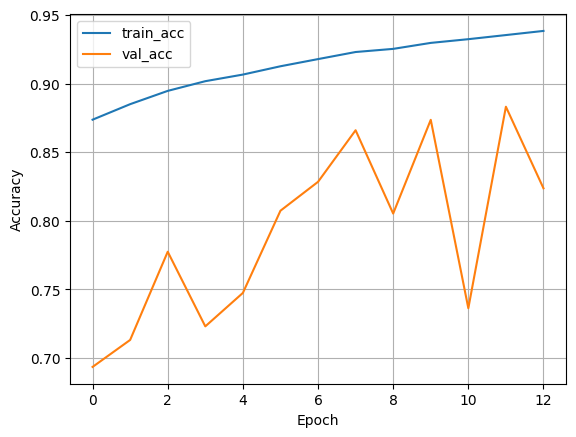

In [17]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()